In [2]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [3]:
from nmt_run import *

In [4]:
%run utils.ipynb

In [5]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [6]:
google_s2t_hyps, google_s2t_refs, google_s2t_refs_for_eval = get_google_data()
google_hyp_r0 = google_s2t_hyps['fisher_dev_r0']
google_dev_ref_0 = google_s2t_refs['fisher_dev_ref_0']

eval refs found, loading


In [7]:
# model_names = {
#     "simple": "emb_sp2enw/sp_0.33_seed-AA",
#     "sample_mix": "emb_sp2enw/sp_0.33_seed-AA_mix-0.5/",
# }

In [8]:
# model_names = {
#     "simple": "sp2enw_mel-80_vocab-nltk/sp_0.50_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln",
#     "sample_mix": "sp2enw_mel-80_vocab-nltk/sp_0.50_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln_sample/",
# }

In [9]:
model_names = {
    "simple": "./sp2enw_interspeech/sp_0.33_seed-AB_l2e-4_drpt-0.5",
    "sample_mix": "./sp2enw_interspeech/sp_0.33_seed-AB_l2e-4_drpt-0.5_sample-mix-0.5",
}

In [10]:
model_data = {}
for m, m_loc in model_names.items():
    model_data[m] ={"refs": {}, "hyps": {}, "refs_eval": {}, "log_train": [], "log_dev": []}
    model_data[m]["refs"] = pickle.load(open(os.path.join(m_loc, "model_s2t_refs.dict"), "rb"))
    model_data[m]["hyps"] = pickle.load(open(os.path.join(m_loc, "model_s2t_hyps.dict"), "rb"))
    model_data[m]["refs_eval"] = pickle.load(open(os.path.join(m_loc, "model_s2t_refs_for_eval.dict"), "rb"))
    model_data[m]["log_train"] = np.loadtxt(os.path.join(m_loc, "train.log"), delimiter=',', skiprows=False).transpose()
    model_data[m]["log_dev"] = np.genfromtxt(os.path.join(m_loc, "dev.log"), delimiter=',', usecols = (0,1,2)).transpose()

In [11]:
model_data["sample_mix"]["refs_eval"]['20051009_182032_217_fsp-A-1']

[['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon']]

In [12]:
model_data["sample_mix"]["refs"]['20051009_182032_217_fsp-A-1']

['good', 'afternoon']

In [13]:
model_data["sample_mix"]["hyps"]['20051009_182032_217_fsp-A-1']

['good', 'afternon']

In [14]:
nltk.translate.bleu_score.sentence_bleu(model_data["sample_mix"]["refs_eval"]['20051009_182032_217_fsp-A-1'],
                                       model_data["sample_mix"]["hyps"]['20051009_182032_217_fsp-A-1'],
                                       smoothing_function=smooth_fun.method2)

0.537284965911771

In [15]:
nltk.translate.bleu_score.sentence_bleu(model_data["simple"]["refs_eval"]['20051009_182032_217_fsp-A-1'],
                                       model_data["simple"]["hyps"]['20051009_182032_217_fsp-A-1'],
                                       smoothing_function=smooth_fun.method2)

0.7071067811865476

In [16]:
all_dev_utts= set(model_data["sample_mix"]["refs_eval"].keys()) & set(model_data["simple"]["refs_eval"].keys())

In [17]:
len(all_dev_utts)

3977

### Train, Dev loss and BLEU

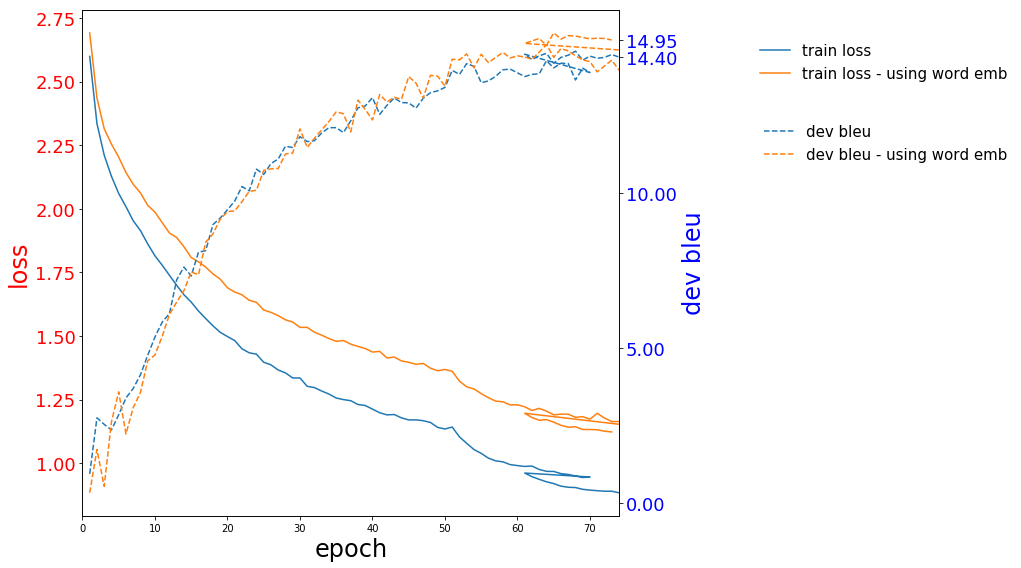

In [18]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,8)
ax1.plot(model_data["simple"]["log_train"][0], model_data["simple"]["log_train"][1], 
         color=tableau20[0], label="train loss")
ax1.plot(model_data["sample_mix"]["log_train"][0], model_data["sample_mix"]["log_train"][1], 
         color=tableau20[2], label="train loss - using word emb")
# ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(bbox_to_anchor=(1.75, 0.96), framealpha=0, fontsize=15)    
ax2 = ax1.twinx()
ax2.plot(model_data["simple"]["log_dev"][0], model_data["simple"]["log_dev"][2]*100, 
         color=tableau20[0], label="dev bleu", linestyle="--")
ax2.plot(model_data["sample_mix"]["log_dev"][0], model_data["sample_mix"]["log_dev"][2]*100,
         color=tableau20[2], label="dev bleu - using word emb", linestyle="--")
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)

# ax2.axhline(y=model_data["sample_mix"]["log_dev"][2][-1]*100, linewidth=1, color="k")
max_bleu_simple = model_data["simple"]["log_dev"][2][-1]*100
max_blue_mix = model_data["sample_mix"]["log_dev"][2][-1]*100

# plt.yticks(list(plt.yticks()[0]) + [max_bleu_simple, max_blue_mix])
plt.yticks(list(range(0,12,5)) + [max_bleu_simple, max_blue_mix])

ax1.set_xlim(0, model_data["simple"]["log_dev"][0][-1])
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(bbox_to_anchor=(1.75, 0.8), framealpha=0, fontsize=15)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

### Utterance level comparison

In [19]:
m_a = "simple"
m_b = "sample_mix"

In [17]:
MIN_LEN = 10

In [18]:
def check_bleu_with_len_filter(m_data, min_len):
    sel_refs, sel_hyps = [], []
    for u in m_data["refs_eval"]:
        len_ref = min([len(r) for r in m_data["refs_eval"][u]])
        if len_ref >= min_len:
            sel_refs.append(m_data["refs_eval"][u])
            sel_hyps.append(m_data["hyps"][u])
    print("{0:d} out of {1:d} have len >= {2:d}".format(len(sel_refs), len(m_data["refs_eval"]), min_len))
    bleu_score = corpus_bleu(sel_refs, sel_hyps, smoothing_function=smooth_fun.method2)*100
    print("BLEU={0:.2f}".format(bleu_score))
    sel_p, sel_r, _ = basic_precision_recall(sel_refs, sel_hyps)
    print("precision={0:.2f}, recall={1:.2f}".format(sel_p, sel_r))

In [19]:
check_bleu_with_len_filter(model_data[m_a], min_len=1)
check_bleu_with_len_filter(model_data[m_b], min_len=1)

3977 out of 3977 have len >= 1
BLEU=14.57
precision=49.57, recall=42.39
3977 out of 3977 have len >= 1
BLEU=15.07
precision=51.15, recall=43.46


In [20]:
check_bleu_with_len_filter(model_data[m_a], min_len=MIN_LEN)

1430 out of 3977 have len >= 10
BLEU=14.32
precision=49.95, recall=41.29


In [21]:
check_bleu_with_len_filter(model_data[m_b], min_len=MIN_LEN)

1430 out of 3977 have len >= 10
BLEU=14.89
precision=51.67, recall=42.35


In [22]:
utts_bleu = {m_a: {}, m_b: {}}

for utt in tqdm(all_dev_utts, ncols=80):
    utts_bleu[m_a][utt] = sentence_bleu(model_data[m_a]["refs_eval"][utt], 
                               model_data[m_a]["hyps"][utt], 
                               smoothing_function=smooth_fun.method2)
    utts_bleu[m_b][utt] = sentence_bleu(model_data[m_b]["refs_eval"][utt], 
                               model_data[m_b]["hyps"][utt], 
                               smoothing_function=smooth_fun.method2)

100%|██████████████████████████████████████| 3977/3977 [00:04<00:00, 865.20it/s]


In [23]:
all_above_min_len = 0
utts_a_better = []
utts_b_better = []

for utt in tqdm(all_dev_utts, ncols=80):
    if len(model_data[m_b]["refs"][utt]) > MIN_LEN:
        all_above_min_len += 1
        if utts_bleu[m_a][utt] > utts_bleu[m_b][utt]:
            utts_a_better.append(utt)
        elif utts_bleu[m_b][utt] > utts_bleu[m_a][utt]:
            utts_b_better.append(utt)

100%|███████████████████████████████████| 3977/3977 [00:00<00:00, 400642.42it/s]


In [24]:
len(utts_a_better), len(utts_b_better), all_above_min_len

(707, 787, 1506)

In [25]:
len(utts_b_better) - len(utts_a_better)

80

In [26]:
np.mean([utts_bleu[m_a][u]-utts_bleu[m_b][u] for u in utts_a_better])

0.06529867882568795

In [27]:
np.mean([utts_bleu[m_b][u]-utts_bleu[m_a][u] for u in utts_b_better])

0.0689567547569761

In [28]:
np.mean([len(model_data[m_a]["hyps"][u]) for u in utts_a_better]), np.std([len(model_data[m_a]["hyps"][u]) for u in utts_a_better])

(20.11315417256011, 8.071370788284565)

In [29]:
np.mean([len(model_data[m_b]["hyps"][u]) for u in utts_b_better]), np.std([len(model_data[m_b]["hyps"][u]) for u in utts_b_better])

(20.147395171537482, 8.286706655360561)

In [30]:
bleu_diff = {u: utts_bleu[m_b][u]-utts_bleu[m_a][u] for u in all_dev_utts if len(model_data[m_b]["refs"][u]) > MIN_LEN}

In [31]:
best_b = sorted(bleu_diff.items(), reverse=True, key=lambda t:t[1])[:10]

In [32]:
best_a = sorted(bleu_diff.items(), key=lambda t:t[1])[:10]

In [33]:
best_b

[('20051017_180712_270_fsp-B-2', 0.4797443119192416),
 ('20051017_234550_276_fsp-A-65', 0.45053677286317784),
 ('20051009_182032_217_fsp-B-149', 0.39027530695146495),
 ('20051026_211309_346_fsp-B-8', 0.3730651600660182),
 ('20051018_210220_279_fsp-A-2', 0.3670207933475621),
 ('20051009_182032_217_fsp-B-92', 0.32551877321311473),
 ('20051009_210519_219_fsp-B-61', 0.3213665497428948),
 ('20051018_210744_280_fsp-A-69', 0.3168682217802929),
 ('20051009_182032_217_fsp-B-109', 0.30635914411767307),
 ('20051017_234550_276_fsp-B-48', 0.3016817146534976)]

agglo_dtw_claro.pdf               prep_map_sp_es_en.py
basics.py                         prep_speech_segments.py
bleu_scores_bar.png               prep_vocab.py
bleu_scores.pdf                   __pycache__/
bleu_scores.png                   results_10-25-50-old-google.html
bow_exp.bat*                      results.ipynb
bow_run.py                        results.txt
bow_scratch.ipynb                 run_exp.bat*
common                            s2t_prec_rec.png
common.py                         s2t.sublime-project
create_refs.py                    s2t.sublime-workspace
debug.ipynb                       scratch.ipynb
debug_model.ipynb                 scratch_sru.ipynb
debug_model-with_files.ipynb      scratchy.ipynb
debug_model-with_files-nmt.ipynb  sp2bagwords/
emb_sp2enw/                       sp2enc_mel-80_vocab-nltk/
enc_dec.py                        sp2enw/
esc2esc/                          sp2enw_azure_feb12/
esw2enw/                          sp2enw_hyp_search/
explore_model.ipyn

In [34]:
for u in best_b:
    display_pp = PrettyTable(["cat","sent"], hrules=True)
    display_pp.align = "l"
    display_pp.header = False

    ref_hyp = textwrap.fill(" ".join(model_data[m_b]["refs"][u[0]]),50)
    m_a_hyp = textwrap.fill(" ".join(model_data[m_a]["hyps"][u[0]]),50)
    m_b_hyp = textwrap.fill(" ".join(model_data[m_b]["hyps"][u[0]]),50)

    display_pp.add_row(["utt", u[0]])
    display_pp.add_row(["ref", ref_hyp])
    display_pp.add_row([m_a, m_a_hyp])
    display_pp.add_row([m_b, m_b_hyp])
    
    print(display_pp)

+------------+----------------------------------------------------+
| utt        | 20051017_180712_270_fsp-B-2                        |
+------------+----------------------------------------------------+
| ref        | greetings ah my name is jenny and i 'm calling     |
|            | from new york                                      |
+------------+----------------------------------------------------+
| simple     | good ah i 'm calling from miami and i 'm calling   |
|            | from new york                                      |
+------------+----------------------------------------------------+
| sample_mix | good ah my name is jenny and i 'm calling from new |
|            | york                                               |
+------------+----------------------------------------------------+
+------------+-------------------------------------------------+
| utt        | 20051017_234550_276_fsp-A-65                    |
+------------+----------------------------------------

In [35]:
for u in best_a:
    display_pp = PrettyTable(["cat","sent"], hrules=True)
    display_pp.align = "l"
    display_pp.header = False

    ref_hyp = textwrap.fill(" ".join(model_data[m_b]["refs"][u[0]]),50)
    m_a_hyp = textwrap.fill(" ".join(model_data[m_a]["hyps"][u[0]]),50)
    m_b_hyp = textwrap.fill(" ".join(model_data[m_b]["hyps"][u[0]]),50)

    display_pp.add_row(["utt", u[0]])
    display_pp.add_row(["ref", ref_hyp])
    display_pp.add_row([m_a, m_a_hyp])
    display_pp.add_row([m_b, m_b_hyp])
    
    print(display_pp)

+------------+-------------------------------------------+
| utt        | 20051019_230329_292_fsp-A-3               |
+------------+-------------------------------------------+
| ref        | ah i am i am in idaho and am from chile   |
+------------+-------------------------------------------+
| simple     | ah i 'm i 'm in idaho and i 'm from chile |
+------------+-------------------------------------------+
| sample_mix | ah i 'm from ah i 'm in from chile        |
+------------+-------------------------------------------+
+------------+----------------------------------------------------+
| utt        | 20051017_234550_276_fsp-B-40                       |
+------------+----------------------------------------------------+
| ref        | ah here in in chicago they do a lot of ah puerto   |
|            | rican parade                                       |
+------------+----------------------------------------------------+
| simple     | ah here in chicago there are a puerto rican pu

In [ ]:
nltk.translate.bleu_score.sentence_bleu(model_data["sample_mix"]["refs_eval"]['20051009_182032_217_fsp-A-1'],
                                       model_data["sample_mix"]["hyps"]['20051009_182032_217_fsp-A-1'],
                                       smoothing_function=smooth_fun.method2)

### sp_0.33 experiments

### Dev set performance 
```
_no sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** dev bleu=0.1254
********** dev: prec=46.709, recall=40.369

_sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** dev bleu=0.1338
********** dev: prec=47.333, recall=41.707
```
### Test set performance 

```
_no sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** test bleu=0.1211
********** test: prec=46.556, recall=40.643


_sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** test bleu=0.1265
********** test: prec=46.967, recall=41.969
```